In [34]:
import random
import torch
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import random
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [35]:
def load_and_preprocess_player_data(batting_path, pitching_path, max_year=2024):
    batter = pd.read_csv(batting_path)
    pitcher = pd.read_csv(pitching_path)
    
    batter['is_pitcher'] = 0
    pitcher['is_pitcher'] = 1
    
    combined_df = pd.concat([batter, pitcher], axis=0, ignore_index=True)
    
    drop_cols = ['Id', 'Name', 'Birthdate', 'School', 'Draft']
    df = combined_df.drop(columns=drop_cols)
    
    df = df[df['Year'] <= max_year]
    
    le_team = LabelEncoder()
    le_hand = LabelEncoder()
    le_pos = LabelEncoder()
    
    df['Team'] = le_team.fit_transform(df['Team'].astype(str))
    df['Handedness'] = le_hand.fit_transform(df['Handedness'].astype(str))
    df['Pos.'] = le_pos.fit_transform(df['Pos.'].astype(str))
    
    df = df.fillna(0)
    
    print(f"Player data loaded: {df.shape[0]:,} players, {df.shape[1]} features")
    print(f"Data period: {df['Year'].min()} ~ {df['Year'].max()}")
    
    return df

player_df = load_and_preprocess_player_data(
    'data/raw/kbo_batting_stats_by_season_1982-2025.csv',
    'data/raw/kbo_pitching_stats_by_season_1982-2025.csv',
    max_year=2025
 )

Player data loaded: 17,458 players, 56 features
Data period: 1982 ~ 2025


In [36]:
from sklearn.preprocessing import StandardScaler

def prepare_scaled_data(df, test_size=0.2):
    X = df.values.astype(np.float32)
    
    X_train, X_val = train_test_split(X, test_size=test_size, shuffle=False)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    print(f"Data split completed")
    print(f"Training data: {X_train_scaled.shape}")
    print(f"Validation data: {X_val_scaled.shape}")
    
    return X_train_scaled, X_val_scaled, scaler

X_player_train, X_player_val, player_scaler = prepare_scaled_data(player_df)

Data split completed
Training data: (13966, 56)
Validation data: (3492, 56)


In [37]:
from pytorch_tabnet.pretraining import TabNetPretrainer

pretrainer = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',
    n_d=32,
    n_a=32,
    device_name=device
)

print("player data pretraining start...")

pretrainer.fit(
    X_train=X_player_train,
    eval_set=[X_player_val],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    pretraining_ratio=0.3
)

print("\nPretraining completed!")
pretrainer.save_model('./models/kbo_pretrainer')
print("Model saved: ./models/kbo_pretrainer")

player data pretraining start...


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")
/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0  | loss: 118.2726| val_0_unsup_loss_numpy: 522026385408.0|  0:00:01s
epoch 1  | loss: 1.05621 | val_0_unsup_loss_numpy: 18540468224.0|  0:00:02s
epoch 2  | loss: 12.19862| val_0_unsup_loss_numpy: 5712994304.0|  0:00:03s
epoch 3  | loss: 5.93498 | val_0_unsup_loss_numpy: 5773433344.0|  0:00:04s
epoch 4  | loss: 6.51607 | val_0_unsup_loss_numpy: 6007197696.0|  0:00:05s
epoch 5  | loss: 1.1522  | val_0_unsup_loss_numpy: 3290692864.0|  0:00:06s
epoch 6  | loss: 0.47101 | val_0_unsup_loss_numpy: 2733262080.0|  0:00:07s
epoch 7  | loss: 2.03713 | val_0_unsup_loss_numpy: 3566881536.0|  0:00:08s
epoch 8  | loss: 0.60536 | val_0_unsup_loss_numpy: 2317403392.0|  0:00:09s
epoch 9  | loss: 1.4266  | val_0_unsup_loss_numpy: 4936753152.0|  0:00:10s
epoch 10 | loss: 0.91551 | val_0_unsup_loss_numpy: 3183031552.0|  0:00:12s
epoch 11 | loss: 0.77445 | val_0_unsup_loss_numpy: 1986887552.0|  0:00:13s
epoch 12 | loss: 0.56817 | val_0_unsup_loss_numpy: 990085952.0|  0:00:14s
epoch 13 | loss: 0.4728

/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [38]:
import pandas as pd
import numpy as np

def create_team_aggregated_data():
    batter = pd.read_csv('data/raw/kbo_batting_stats_by_season_1982-2025.csv')
    pitcher = pd.read_csv('data/raw/kbo_pitching_stats_by_season_1982-2025.csv')
    team_res = pd.read_csv('data/ranked/kbo_result_ranked_ps.csv')
    
    team_map = {
        'HT': 'KIA', '해태': 'KIA', 'KIA': 'KIA',
        'LT': '롯데', '롯데': '롯데',
        'SS': '삼성', '삼성': '삼성',
        'OB': '두산', '두산': '두산',
        'WO': '키움', '넥센': '키움', '현대': '키움', '키움': '키움',
        'LG': 'LG', 'MBC': 'LG',
        'SK': 'SSG', 'SSG': 'SSG',
        'NC': 'NC', 'KT': 'KT', '한화': '한화', '빙그레': '한화', 'HH': '한화'
    }
    
    batter['Team_Mapped'] = batter['Team'].map(team_map)
    pitcher['Team_Mapped'] = pitcher['Team'].map(team_map)
    team_res['Team_Mapped'] = team_res['TeamID'].map(team_map)
    
    team_batter_agg = batter.groupby(['Year', 'Team_Mapped']).agg({
        'oWAR': 'sum',
        'OPS': 'mean',
        'wRC+': 'mean',
        'R': 'sum'
    }).reset_index()
    
    team_pitcher_agg = pitcher.groupby(['Year', 'Team_Mapped']).agg({
        'WAR': 'sum',
        'FIP': 'mean',
        'WHIP': 'mean',
        'R': 'sum'
    }).rename(columns={'WAR': 'pWAR_sum', 'R': 'Total_RA'}).reset_index()
    
    expanded = pd.merge(team_res, team_batter_agg, on=['Year', 'Team_Mapped'], how='left')
    expanded = pd.merge(expanded, team_pitcher_agg, on=['Year', 'Team_Mapped'], how='left')
    
    r_col = 'R' if 'R' in expanded.columns else 'R_x'
    expanded['Pyth_WPCT'] = (expanded[r_col]**2) / (
        expanded[r_col]**2 + expanded['Total_RA']**2 + 1e-6
) * 1000
    
    expanded = expanded.drop(columns=['Team_Mapped']).fillna(0)
    
    print(f"Team data creation completed: {expanded.shape}")
    
    return expanded

team_data = create_team_aggregated_data()
team_data.to_csv('data/kbo_result_ranked_ps_expanded.csv', index=False, encoding='utf-8-sig')

Team data creation completed: (363, 21)


In [39]:
results = pd.read_csv('data/kbo_result_ranked_ps_expanded.csv')
results = results.sort_values(['TeamID', 'Year'])

if results['WPCT'].max() > 1:
    results['WPCT_norm'] = results['WPCT'] / 1000
else:
    results['WPCT_norm'] = results['WPCT']

print("Team data statistics:")
print(results[['Year', 'TeamID', 'Team', 'WPCT_norm', 'ERA']].head(10))

Team data statistics:
    Year TeamID     Team  WPCT_norm   ERA
30  1986     HH  빙그레 이글스      0.290  3.65
36  1987     HH  빙그레 이글스      0.454  3.78
39  1988     HH  빙그레 이글스      0.579  3.72
45  1989     HH  빙그레 이글스      0.604  3.47
54  1990     HH  빙그레 이글스      0.575  3.40
60  1991     HH  빙그레 이글스      0.591  3.28
67  1992     HH  빙그레 이글스      0.651  3.68
79  1993     HH  빙그레 이글스      0.500  3.46
85  1994     HH   한화 이글스      0.524  3.52
96  1995     HH   한화 이글스      0.437  4.04


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

feature_cols = ['OPS', 'wRC+', 'oWAR', 'FIP', 'WHIP', 'pWAR_sum', 'Pyth_WPCT', 'PS']

def create_time_series_data(df, window_size=3, total_features=56, forecast_year=None):

    if forecast_year:
        df_filtered = df[df['Year'] < forecast_year].copy()
    else:
        df_filtered = df.copy()
    
    X, y, metadata = [], [], []
    
    for team in df_filtered['TeamID'].unique():
        team_data = df_filtered[df_filtered['TeamID'] == team].sort_values('Year')
        
        if len(team_data) <= window_size:
            continue
        
        for i in range(len(team_data) - window_size):
            window_stats = team_data.iloc[i : i + window_size][feature_cols].values.flatten()
            
            padding_size = total_features - len(window_stats)
            padding = np.zeros(padding_size)
            full_window = np.concatenate([window_stats, padding])
            
            target_year = team_data.iloc[i + window_size]['Year']
            target_wpct = team_data.iloc[i + window_size]['WPCT_norm']
            
            X.append(full_window)
            y.append(target_wpct)
            metadata.append({
                'team': team,
                'years': f"{team_data.iloc[i]['Year']}-{team_data.iloc[i + window_size - 1]['Year']}",
                'target_year': target_year
            })
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    print(f"Time series data creation completed:")
    print(f"   Number of samples: {len(X):,}")
    print(f"   Feature dimension: {X.shape[1]} (window {window_size} years × {len(feature_cols)} features + padding)")
    print(f"   Target variable range: {y.min():.3f} ~ {y.max():.3f}")
    
    return X, y, metadata

train_val_raw_df = results[results['Year'] <= 2024]
X_full, y_full, meta_full = create_time_series_data(train_val_raw_df, window_size=3, total_features=56)

def split_time_series_data(X, y, val_ratio=0.15, test_ratio=0.15):
    
    n = len(X)
    train_end = int(n * (1 - val_ratio - test_ratio))
    val_end = int(n * (1 - test_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    print(f"\nData split completed:")
    print(f"   Train: {len(X_train)} ({len(X_train)/n*100:.1f}%)")
    print(f"   Val:   {len(X_val)} ({len(X_val)/n*100:.1f}%)")
    print(f"   Test:  {len(X_test)} ({len(X_test)/n*100:.1f}%)")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

scaler_team = StandardScaler()

(X_train_raw, y_train), (X_val_raw, y_val), (X_test_raw, y_test) = split_time_series_data(
    X_full, y_full
)

X_train = scaler_team.fit_transform(X_train_raw)
X_val = scaler_team.transform(X_val_raw)
X_test = scaler_team.transform(X_test_raw)

print(f"\nScaled data shape:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")

Time series data creation completed:
   Number of samples: 323
   Feature dimension: 56 (window 3 years × 8 features + padding)
   Target variable range: 0.224 ~ 0.706

Data split completed:
   Train: 226 (70.0%)
   Val:   48 (14.9%)
   Test:  49 (15.2%)

Scaled data shape:
   X_train: (226, 56)
   X_val: (48, 56)
   X_test: (49, 56)


In [41]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    eval_results = {
        'model': model_name,
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    return eval_results, model

ridge_results, ridge_model = evaluate_model(
    Ridge(alpha=1.0),
    X_train, y_train, X_val, y_val, X_test, y_test,
    "Ridge Regression"
)

rf_results, rf_model = evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val, X_test, y_test,
    "Random Forest"
)


for eval_result in [ridge_results, rf_results]:
    print(f"\n{eval_result['model']}")
    print(f"   Train - RMSE: {eval_result['train_rmse']:.4f}, MAE: {eval_result['train_mae']:.4f}, R²: {eval_result['train_r2']:.4f}")
    print(f"   Val   - RMSE: {eval_result['val_rmse']:.4f}, MAE: {eval_result['val_mae']:.4f}, R²: {eval_result['val_r2']:.4f}")
    print(f"   Test  - RMSE: {eval_result['test_rmse']:.4f}, MAE: {eval_result['test_mae']:.4f}, R²: {eval_result['test_r2']:.4f}")


Ridge Regression
   Train - RMSE: 0.0663, MAE: 0.0524, R²: 0.2782
   Val   - RMSE: 0.0735, MAE: 0.0578, R²: -0.3286
   Test  - RMSE: 0.0794, MAE: 0.0645, R²: 0.1962

Random Forest
   Train - RMSE: 0.0287, MAE: 0.0224, R²: 0.8646
   Val   - RMSE: 0.0723, MAE: 0.0561, R²: -0.2884
   Test  - RMSE: 0.0835, MAE: 0.0712, R²: 0.1109


In [42]:
from pytorch_tabnet.tab_model import TabNetRegressor

regressor = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    device_name=device,
    n_d=32,
    n_a=32
)


regressor.fit(
    X_train=X_train,
    y_train=y_train.reshape(-1, 1),
    eval_set=[(X_val, y_val.reshape(-1, 1))],
    eval_name=['validation'],
    eval_metric=['rmse', 'mae'],
    from_unsupervised=pretrainer,
    max_epochs=200,
    patience=30,
    batch_size=32,
    virtual_batch_size=16,
    loss_fn=torch.nn.functional.mse_loss
)

regressor.save_model('./models/kbo_tabnet_regressor')

/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")
/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")
/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0  | loss: 4.2493  | validation_rmse: 1.52273 | validation_mae: 0.8061  |  0:00:00s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 1  | loss: 2.98533 | validation_rmse: 1.20742 | validation_mae: 0.68098 |  0:00:00s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2  | loss: 1.47114 | validation_rmse: 0.93545 | validation_mae: 0.53846 |  0:00:00s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3  | loss: 0.99228 | validation_rmse: 0.79686 | validation_mae: 0.48316 |  0:00:00s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 4  | loss: 0.54584 | validation_rmse: 0.66387 | validation_mae: 0.42863 |  0:00:01s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 5  | loss: 0.42946 | validation_rmse: 0.56129 | validation_mae: 0.38751 |  0:00:01s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 6  | loss: 0.37973 | validation_rmse: 0.52887 | validation_mae: 0.36124 |  0:00:01s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 7  | loss: 0.35193 | validation_rmse: 0.47735 | validation_mae: 0.32223 |  0:00:01s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 8  | loss: 0.24991 | validation_rmse: 0.48868 | validation_mae: 0.31783 |  0:00:02s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 9  | loss: 0.22336 | validation_rmse: 0.4354  | validation_mae: 0.29142 |  0:00:02s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 10 | loss: 0.19607 | validation_rmse: 0.31756 | validation_mae: 0.24319 |  0:00:02s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 11 | loss: 0.177   | validation_rmse: 0.33974 | validation_mae: 0.24151 |  0:00:02s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 12 | loss: 0.15738 | validation_rmse: 0.2707  | validation_mae: 0.20386 |  0:00:02s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 13 | loss: 0.12931 | validation_rmse: 0.23468 | validation_mae: 0.18299 |  0:00:03s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 14 | loss: 0.14584 | validation_rmse: 0.22143 | validation_mae: 0.16902 |  0:00:03s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 15 | loss: 0.11586 | validation_rmse: 0.27383 | validation_mae: 0.19818 |  0:00:03s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 16 | loss: 0.09885 | validation_rmse: 0.2082  | validation_mae: 0.1601  |  0:00:03s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 17 | loss: 0.08102 | validation_rmse: 0.18993 | validation_mae: 0.14915 |  0:00:04s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 18 | loss: 0.10755 | validation_rmse: 0.18867 | validation_mae: 0.14275 |  0:00:04s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 19 | loss: 0.10396 | validation_rmse: 0.22242 | validation_mae: 0.15824 |  0:00:04s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 20 | loss: 0.09729 | validation_rmse: 0.18944 | validation_mae: 0.15073 |  0:00:04s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 21 | loss: 0.09012 | validation_rmse: 0.21919 | validation_mae: 0.15924 |  0:00:04s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 22 | loss: 0.07921 | validation_rmse: 0.21281 | validation_mae: 0.15745 |  0:00:05s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 23 | loss: 0.07189 | validation_rmse: 0.21909 | validation_mae: 0.16042 |  0:00:05s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 24 | loss: 0.08352 | validation_rmse: 0.20195 | validation_mae: 0.14556 |  0:00:05s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 25 | loss: 0.06763 | validation_rmse: 0.20339 | validation_mae: 0.14774 |  0:00:05s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 26 | loss: 0.08856 | validation_rmse: 0.18935 | validation_mae: 0.13733 |  0:00:06s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 27 | loss: 0.0449  | validation_rmse: 0.16958 | validation_mae: 0.13207 |  0:00:06s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 28 | loss: 0.06248 | validation_rmse: 0.15198 | validation_mae: 0.12121 |  0:00:06s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 29 | loss: 0.05456 | validation_rmse: 0.20193 | validation_mae: 0.14357 |  0:00:06s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 30 | loss: 0.06634 | validation_rmse: 0.16427 | validation_mae: 0.12055 |  0:00:07s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 31 | loss: 0.04288 | validation_rmse: 0.16859 | validation_mae: 0.12708 |  0:00:07s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 32 | loss: 0.04735 | validation_rmse: 0.18397 | validation_mae: 0.12584 |  0:00:07s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 33 | loss: 0.04661 | validation_rmse: 0.21011 | validation_mae: 0.12795 |  0:00:07s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 34 | loss: 0.08061 | validation_rmse: 0.20393 | validation_mae: 0.13668 |  0:00:08s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 35 | loss: 0.04427 | validation_rmse: 0.16444 | validation_mae: 0.11841 |  0:00:08s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 36 | loss: 0.03477 | validation_rmse: 0.18831 | validation_mae: 0.11331 |  0:00:08s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 37 | loss: 0.0546  | validation_rmse: 0.19635 | validation_mae: 0.13281 |  0:00:08s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 38 | loss: 0.04689 | validation_rmse: 0.17603 | validation_mae: 0.11739 |  0:00:08s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 39 | loss: 0.0392  | validation_rmse: 0.16042 | validation_mae: 0.11767 |  0:00:09s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 40 | loss: 0.04088 | validation_rmse: 0.20351 | validation_mae: 0.11857 |  0:00:09s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 41 | loss: 0.04269 | validation_rmse: 0.18793 | validation_mae: 0.11352 |  0:00:09s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 42 | loss: 0.04247 | validation_rmse: 0.21555 | validation_mae: 0.1337  |  0:00:09s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 43 | loss: 0.04371 | validation_rmse: 0.25154 | validation_mae: 0.13859 |  0:00:10s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 44 | loss: 0.04077 | validation_rmse: 0.22217 | validation_mae: 0.13501 |  0:00:10s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 45 | loss: 0.04016 | validation_rmse: 0.22543 | validation_mae: 0.12522 |  0:00:10s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 46 | loss: 0.03501 | validation_rmse: 0.25178 | validation_mae: 0.13706 |  0:00:10s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 47 | loss: 0.0293  | validation_rmse: 0.22699 | validation_mae: 0.12615 |  0:00:10s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 48 | loss: 0.03485 | validation_rmse: 0.23048 | validation_mae: 0.13735 |  0:00:11s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 49 | loss: 0.03009 | validation_rmse: 0.31673 | validation_mae: 0.15967 |  0:00:11s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 50 | loss: 0.03513 | validation_rmse: 0.2837  | validation_mae: 0.16025 |  0:00:11s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 51 | loss: 0.02527 | validation_rmse: 0.24085 | validation_mae: 0.13575 |  0:00:11s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 52 | loss: 0.03059 | validation_rmse: 0.2204  | validation_mae: 0.12576 |  0:00:12s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 53 | loss: 0.03298 | validation_rmse: 0.16412 | validation_mae: 0.11252 |  0:00:12s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 54 | loss: 0.03105 | validation_rmse: 0.15814 | validation_mae: 0.11818 |  0:00:12s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 55 | loss: 0.02763 | validation_rmse: 0.20782 | validation_mae: 0.12178 |  0:00:12s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 56 | loss: 0.02597 | validation_rmse: 0.23376 | validation_mae: 0.1368  |  0:00:13s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 57 | loss: 0.03057 | validation_rmse: 0.22133 | validation_mae: 0.14712 |  0:00:13s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 58 | loss: 0.02848 | validation_rmse: 0.20164 | validation_mae: 0.12147 |  0:00:13s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 59 | loss: 0.0279  | validation_rmse: 0.21865 | validation_mae: 0.12787 |  0:00:13s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 60 | loss: 0.02328 | validation_rmse: 0.16522 | validation_mae: 0.11036 |  0:00:14s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 61 | loss: 0.02041 | validation_rmse: 0.14838 | validation_mae: 0.10684 |  0:00:14s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 62 | loss: 0.02469 | validation_rmse: 0.1693  | validation_mae: 0.11989 |  0:00:14s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 63 | loss: 0.02476 | validation_rmse: 0.15169 | validation_mae: 0.0945  |  0:00:14s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 64 | loss: 0.02596 | validation_rmse: 0.12421 | validation_mae: 0.09594 |  0:00:15s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 65 | loss: 0.03083 | validation_rmse: 0.16088 | validation_mae: 0.1087  |  0:00:15s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 66 | loss: 0.02588 | validation_rmse: 0.1337  | validation_mae: 0.10418 |  0:00:15s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 67 | loss: 0.0222  | validation_rmse: 0.14266 | validation_mae: 0.09721 |  0:00:15s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 68 | loss: 0.02191 | validation_rmse: 0.15293 | validation_mae: 0.10246 |  0:00:15s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 69 | loss: 0.02298 | validation_rmse: 0.13659 | validation_mae: 0.10058 |  0:00:16s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 70 | loss: 0.01996 | validation_rmse: 0.13937 | validation_mae: 0.10268 |  0:00:16s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 71 | loss: 0.0217  | validation_rmse: 0.12897 | validation_mae: 0.1014  |  0:00:16s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 72 | loss: 0.02313 | validation_rmse: 0.13554 | validation_mae: 0.11005 |  0:00:16s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 73 | loss: 0.02235 | validation_rmse: 0.13626 | validation_mae: 0.10502 |  0:00:17s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 74 | loss: 0.01603 | validation_rmse: 0.1388  | validation_mae: 0.10299 |  0:00:17s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 75 | loss: 0.02136 | validation_rmse: 0.13733 | validation_mae: 0.09903 |  0:00:17s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 76 | loss: 0.01676 | validation_rmse: 0.1441  | validation_mae: 0.09305 |  0:00:17s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 77 | loss: 0.01905 | validation_rmse: 0.16112 | validation_mae: 0.10416 |  0:00:18s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 78 | loss: 0.02084 | validation_rmse: 0.15481 | validation_mae: 0.10705 |  0:00:18s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 79 | loss: 0.01843 | validation_rmse: 0.17386 | validation_mae: 0.1092  |  0:00:18s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 80 | loss: 0.02127 | validation_rmse: 0.14609 | validation_mae: 0.1035  |  0:00:18s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 81 | loss: 0.01898 | validation_rmse: 0.1429  | validation_mae: 0.09694 |  0:00:19s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 82 | loss: 0.01819 | validation_rmse: 0.16894 | validation_mae: 0.10486 |  0:00:19s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 83 | loss: 0.02005 | validation_rmse: 0.15004 | validation_mae: 0.09693 |  0:00:19s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 84 | loss: 0.01785 | validation_rmse: 0.1444  | validation_mae: 0.10276 |  0:00:19s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 85 | loss: 0.01826 | validation_rmse: 0.18185 | validation_mae: 0.10665 |  0:00:20s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 86 | loss: 0.01546 | validation_rmse: 0.15547 | validation_mae: 0.10179 |  0:00:20s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 87 | loss: 0.02128 | validation_rmse: 0.11818 | validation_mae: 0.09117 |  0:00:20s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 88 | loss: 0.01693 | validation_rmse: 0.13151 | validation_mae: 0.0933  |  0:00:20s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 89 | loss: 0.01513 | validation_rmse: 0.13729 | validation_mae: 0.09599 |  0:00:21s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 90 | loss: 0.01679 | validation_rmse: 0.1375  | validation_mae: 0.09758 |  0:00:21s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 91 | loss: 0.0168  | validation_rmse: 0.1308  | validation_mae: 0.09211 |  0:00:21s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 92 | loss: 0.01601 | validation_rmse: 0.1373  | validation_mae: 0.08862 |  0:00:21s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 93 | loss: 0.0157  | validation_rmse: 0.13132 | validation_mae: 0.09064 |  0:00:22s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 94 | loss: 0.01759 | validation_rmse: 0.14332 | validation_mae: 0.09123 |  0:00:22s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 95 | loss: 0.01237 | validation_rmse: 0.15043 | validation_mae: 0.09904 |  0:00:22s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 96 | loss: 0.01867 | validation_rmse: 0.12673 | validation_mae: 0.09144 |  0:00:22s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 97 | loss: 0.01559 | validation_rmse: 0.1251  | validation_mae: 0.09052 |  0:00:23s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 98 | loss: 0.01664 | validation_rmse: 0.1247  | validation_mae: 0.08852 |  0:00:23s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 99 | loss: 0.01738 | validation_rmse: 0.12302 | validation_mae: 0.08895 |  0:00:23s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 100| loss: 0.01768 | validation_rmse: 0.11702 | validation_mae: 0.09007 |  0:00:23s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 101| loss: 0.01619 | validation_rmse: 0.11523 | validation_mae: 0.08637 |  0:00:24s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 102| loss: 0.01726 | validation_rmse: 0.1228  | validation_mae: 0.09246 |  0:00:24s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 103| loss: 0.0149  | validation_rmse: 0.13298 | validation_mae: 0.10365 |  0:00:24s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 104| loss: 0.01814 | validation_rmse: 0.11904 | validation_mae: 0.08473 |  0:00:24s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 105| loss: 0.01656 | validation_rmse: 0.12898 | validation_mae: 0.0945  |  0:00:25s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 106| loss: 0.01399 | validation_rmse: 0.13079 | validation_mae: 0.09452 |  0:00:25s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 107| loss: 0.01615 | validation_rmse: 0.13166 | validation_mae: 0.10617 |  0:00:25s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 108| loss: 0.01502 | validation_rmse: 0.13233 | validation_mae: 0.09282 |  0:00:25s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 109| loss: 0.01671 | validation_rmse: 0.13681 | validation_mae: 0.10673 |  0:00:26s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 110| loss: 0.01282 | validation_rmse: 0.13938 | validation_mae: 0.09747 |  0:00:26s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 111| loss: 0.01788 | validation_rmse: 0.14332 | validation_mae: 0.09098 |  0:00:26s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 112| loss: 0.01541 | validation_rmse: 0.13081 | validation_mae: 0.09553 |  0:00:26s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 113| loss: 0.01353 | validation_rmse: 0.11684 | validation_mae: 0.09193 |  0:00:27s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 114| loss: 0.01717 | validation_rmse: 0.12874 | validation_mae: 0.09057 |  0:00:27s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 115| loss: 0.01538 | validation_rmse: 0.13498 | validation_mae: 0.10318 |  0:00:27s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 116| loss: 0.01593 | validation_rmse: 0.12787 | validation_mae: 0.08617 |  0:00:27s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 117| loss: 0.01453 | validation_rmse: 0.12093 | validation_mae: 0.09178 |  0:00:28s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 118| loss: 0.01509 | validation_rmse: 0.11299 | validation_mae: 0.08048 |  0:00:28s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 119| loss: 0.01475 | validation_rmse: 0.15117 | validation_mae: 0.09713 |  0:00:28s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 120| loss: 0.01708 | validation_rmse: 0.11665 | validation_mae: 0.08424 |  0:00:28s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 121| loss: 0.01263 | validation_rmse: 0.13142 | validation_mae: 0.09265 |  0:00:29s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 122| loss: 0.01503 | validation_rmse: 0.15462 | validation_mae: 0.10586 |  0:00:29s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 123| loss: 0.01327 | validation_rmse: 0.11814 | validation_mae: 0.09188 |  0:00:29s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 124| loss: 0.01603 | validation_rmse: 0.11941 | validation_mae: 0.08824 |  0:00:29s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 125| loss: 0.01881 | validation_rmse: 0.14727 | validation_mae: 0.10109 |  0:00:30s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 126| loss: 0.01549 | validation_rmse: 0.11005 | validation_mae: 0.08895 |  0:00:30s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 127| loss: 0.017   | validation_rmse: 0.12029 | validation_mae: 0.09982 |  0:00:30s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 128| loss: 0.01363 | validation_rmse: 0.11729 | validation_mae: 0.0878  |  0:00:30s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 129| loss: 0.01444 | validation_rmse: 0.10837 | validation_mae: 0.08958 |  0:00:31s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 130| loss: 0.01323 | validation_rmse: 0.09736 | validation_mae: 0.08314 |  0:00:31s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 131| loss: 0.01411 | validation_rmse: 0.10778 | validation_mae: 0.08818 |  0:00:31s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 132| loss: 0.0126  | validation_rmse: 0.12421 | validation_mae: 0.09494 |  0:00:31s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 133| loss: 0.01277 | validation_rmse: 0.11299 | validation_mae: 0.09245 |  0:00:32s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 134| loss: 0.01416 | validation_rmse: 0.10122 | validation_mae: 0.08499 |  0:00:32s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 135| loss: 0.01522 | validation_rmse: 0.10806 | validation_mae: 0.09053 |  0:00:32s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 136| loss: 0.01486 | validation_rmse: 0.10881 | validation_mae: 0.08367 |  0:00:33s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 137| loss: 0.01072 | validation_rmse: 0.1073  | validation_mae: 0.08553 |  0:00:33s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 138| loss: 0.01251 | validation_rmse: 0.10676 | validation_mae: 0.08766 |  0:00:33s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 139| loss: 0.011   | validation_rmse: 0.11173 | validation_mae: 0.08649 |  0:00:33s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 140| loss: 0.01365 | validation_rmse: 0.12067 | validation_mae: 0.08767 |  0:00:33s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 141| loss: 0.01383 | validation_rmse: 0.11904 | validation_mae: 0.08803 |  0:00:34s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 142| loss: 0.01425 | validation_rmse: 0.10118 | validation_mae: 0.08354 |  0:00:34s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 143| loss: 0.01829 | validation_rmse: 0.09429 | validation_mae: 0.07943 |  0:00:34s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 144| loss: 0.01481 | validation_rmse: 0.09215 | validation_mae: 0.07914 |  0:00:34s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 145| loss: 0.01487 | validation_rmse: 0.09531 | validation_mae: 0.08112 |  0:00:35s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 146| loss: 0.01156 | validation_rmse: 0.09276 | validation_mae: 0.07699 |  0:00:35s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 147| loss: 0.01617 | validation_rmse: 0.10295 | validation_mae: 0.07956 |  0:00:35s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 148| loss: 0.01208 | validation_rmse: 0.10712 | validation_mae: 0.08617 |  0:00:36s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 149| loss: 0.01428 | validation_rmse: 0.10657 | validation_mae: 0.08491 |  0:00:36s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 150| loss: 0.01024 | validation_rmse: 0.09333 | validation_mae: 0.07666 |  0:00:36s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 151| loss: 0.01402 | validation_rmse: 0.09051 | validation_mae: 0.07484 |  0:00:36s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 152| loss: 0.0129  | validation_rmse: 0.09443 | validation_mae: 0.07934 |  0:00:37s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 153| loss: 0.01405 | validation_rmse: 0.09591 | validation_mae: 0.08038 |  0:00:37s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 154| loss: 0.01101 | validation_rmse: 0.09114 | validation_mae: 0.07622 |  0:00:37s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 155| loss: 0.01458 | validation_rmse: 0.09183 | validation_mae: 0.07733 |  0:00:37s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 156| loss: 0.01104 | validation_rmse: 0.08945 | validation_mae: 0.07514 |  0:00:38s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 157| loss: 0.01332 | validation_rmse: 0.10358 | validation_mae: 0.08673 |  0:00:38s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 158| loss: 0.01437 | validation_rmse: 0.09292 | validation_mae: 0.07431 |  0:00:38s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 159| loss: 0.01363 | validation_rmse: 0.09933 | validation_mae: 0.08086 |  0:00:38s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 160| loss: 0.0118  | validation_rmse: 0.08906 | validation_mae: 0.07142 |  0:00:39s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 161| loss: 0.01149 | validation_rmse: 0.1032  | validation_mae: 0.08568 |  0:00:39s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 162| loss: 0.01496 | validation_rmse: 0.09038 | validation_mae: 0.07534 |  0:00:39s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 163| loss: 0.0123  | validation_rmse: 0.08995 | validation_mae: 0.07436 |  0:00:39s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 164| loss: 0.01214 | validation_rmse: 0.10088 | validation_mae: 0.08515 |  0:00:40s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 165| loss: 0.01122 | validation_rmse: 0.09434 | validation_mae: 0.074   |  0:00:40s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 166| loss: 0.01018 | validation_rmse: 0.09476 | validation_mae: 0.07912 |  0:00:40s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 167| loss: 0.01119 | validation_rmse: 0.09121 | validation_mae: 0.07651 |  0:00:41s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 168| loss: 0.01129 | validation_rmse: 0.09789 | validation_mae: 0.08154 |  0:00:41s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 169| loss: 0.01161 | validation_rmse: 0.08937 | validation_mae: 0.07591 |  0:00:41s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 170| loss: 0.01041 | validation_rmse: 0.09345 | validation_mae: 0.07782 |  0:00:41s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 171| loss: 0.01256 | validation_rmse: 0.09054 | validation_mae: 0.07755 |  0:00:42s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 172| loss: 0.01339 | validation_rmse: 0.09542 | validation_mae: 0.08109 |  0:00:42s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 173| loss: 0.01156 | validation_rmse: 0.0966  | validation_mae: 0.07818 |  0:00:42s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 174| loss: 0.01387 | validation_rmse: 0.10139 | validation_mae: 0.08441 |  0:00:43s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 175| loss: 0.01173 | validation_rmse: 0.0855  | validation_mae: 0.07046 |  0:00:43s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 176| loss: 0.01033 | validation_rmse: 0.1053  | validation_mae: 0.08529 |  0:00:43s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 177| loss: 0.01089 | validation_rmse: 0.08725 | validation_mae: 0.07275 |  0:00:43s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 178| loss: 0.01158 | validation_rmse: 0.08946 | validation_mae: 0.07455 |  0:00:44s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 179| loss: 0.01114 | validation_rmse: 0.09398 | validation_mae: 0.07611 |  0:00:44s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 180| loss: 0.01093 | validation_rmse: 0.09419 | validation_mae: 0.07567 |  0:00:44s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 181| loss: 0.01093 | validation_rmse: 0.09275 | validation_mae: 0.07509 |  0:00:44s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 182| loss: 0.00963 | validation_rmse: 0.09198 | validation_mae: 0.07337 |  0:00:45s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 183| loss: 0.01105 | validation_rmse: 0.10176 | validation_mae: 0.08568 |  0:00:45s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 184| loss: 0.01229 | validation_rmse: 0.09245 | validation_mae: 0.07657 |  0:00:45s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 185| loss: 0.01425 | validation_rmse: 0.0967  | validation_mae: 0.07453 |  0:00:45s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 186| loss: 0.01003 | validation_rmse: 0.09836 | validation_mae: 0.08257 |  0:00:46s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 187| loss: 0.01073 | validation_rmse: 0.08417 | validation_mae: 0.06856 |  0:00:46s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 188| loss: 0.01216 | validation_rmse: 0.09112 | validation_mae: 0.07641 |  0:00:46s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 189| loss: 0.00881 | validation_rmse: 0.08736 | validation_mae: 0.07211 |  0:00:47s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 190| loss: 0.00992 | validation_rmse: 0.09119 | validation_mae: 0.0753  |  0:00:47s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 191| loss: 0.01105 | validation_rmse: 0.08825 | validation_mae: 0.07318 |  0:00:47s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 192| loss: 0.00955 | validation_rmse: 0.08434 | validation_mae: 0.07005 |  0:00:47s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 193| loss: 0.01261 | validation_rmse: 0.08664 | validation_mae: 0.07291 |  0:00:48s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 194| loss: 0.01182 | validation_rmse: 0.09544 | validation_mae: 0.07827 |  0:00:48s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 195| loss: 0.01072 | validation_rmse: 0.08696 | validation_mae: 0.07182 |  0:00:48s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 196| loss: 0.01214 | validation_rmse: 0.08888 | validation_mae: 0.0741  |  0:00:48s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 197| loss: 0.01007 | validation_rmse: 0.09198 | validation_mae: 0.07623 |  0:00:49s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 198| loss: 0.00981 | validation_rmse: 0.09149 | validation_mae: 0.07605 |  0:00:49s


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 199| loss: 0.00994 | validation_rmse: 0.0931  | validation_mae: 0.0765  |  0:00:49s
Stop training because you reached max_epochs = 200 with best_epoch = 187 and best_validation_mae = 0.06856


/Users/minseonkim/Desktop/Code/github/AI_ML/DL-in-Dougout/.venv/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./models/kbo_tabnet_regressor.zip


'./models/kbo_tabnet_regressor.zip'

In [43]:
y_train_pred_tabnet = regressor.predict(X_train).flatten()
y_val_pred_tabnet = regressor.predict(X_val).flatten()
y_test_pred_tabnet = regressor.predict(X_test).flatten()

tabnet_results = {
    'model': 'TabNet (Pretrained)',
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_tabnet)),
    'train_mae': mean_absolute_error(y_train, y_train_pred_tabnet),
    'train_r2': r2_score(y_train, y_train_pred_tabnet),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_tabnet)),
    'val_mae': mean_absolute_error(y_val, y_val_pred_tabnet),
    'val_r2': r2_score(y_val, y_val_pred_tabnet),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_tabnet)),
    'test_mae': mean_absolute_error(y_test, y_test_pred_tabnet),
    'test_r2': r2_score(y_test, y_test_pred_tabnet)
}


print(f"{tabnet_results['model']}")
print(f"   Train - RMSE: {tabnet_results['train_rmse']:.4f}, MAE: {tabnet_results['train_mae']:.4f}, R²: {tabnet_results['train_r2']:.4f}")
print(f"   Val   - RMSE: {tabnet_results['val_rmse']:.4f}, MAE: {tabnet_results['val_mae']:.4f}, R²: {tabnet_results['val_r2']:.4f}")
print(f"   Test  - RMSE: {tabnet_results['test_rmse']:.4f}, MAE: {tabnet_results['test_mae']:.4f}, R²: {tabnet_results['test_r2']:.4f}")

TabNet (Pretrained)
   Train - RMSE: 0.0971, MAE: 0.0723, R²: -0.5451
   Val   - RMSE: 0.0842, MAE: 0.0686, R²: -0.7444
   Test  - RMSE: 0.1104, MAE: 0.0830, R²: -0.5531


In [44]:
comparison_df = pd.DataFrame([ridge_results, rf_results, tabnet_results])


print("Test Set")

print(comparison_df[['model', 'test_rmse', 'test_mae', 'test_r2']].to_string(index=False))

best_model_idx = comparison_df['test_rmse'].idxmin()
best_model_name = comparison_df.iloc[best_model_idx]['model']
print(f"\n최고 성능 모델: {best_model_name}")

ridge_rmse = ridge_results['test_rmse']
tabnet_rmse = tabnet_results['test_rmse']
improvement = ((ridge_rmse - tabnet_rmse) / ridge_rmse) * 100

print(f"\nBaseline(Ridge) 대비 TabNet 개선율: {improvement:+.2f}%")

Test Set
              model  test_rmse  test_mae   test_r2
   Ridge Regression   0.079427  0.064458  0.196182
      Random Forest   0.083537  0.071212  0.110854
TabNet (Pretrained)   0.110406  0.082987 -0.553100

최고 성능 모델: Ridge Regression

Baseline(Ridge) 대비 TabNet 개선율: -39.00%


In [45]:

X_2026_list = []
team_list = []

team_results_df = pd.read_csv('data/kbo_result_ranked_ps_expanded.csv')
team_results_df = team_results_df.sort_values(['TeamID', 'Year'])

if team_results_df['WPCT'].max() > 1:
    team_results_df['WPCT_norm'] = team_results_df['WPCT'] / 1000
else:
    team_results_df['WPCT_norm'] = team_results_df['WPCT']

team_id_col = 'TeamID'

for team in team_results_df[team_id_col].unique():
    team_data = team_results_df[team_results_df[team_id_col] == team].sort_values('Year')
    
    if len(team_data) >= 3:
        latest_3_years = team_data.iloc[-3:][feature_cols].values.flatten()
        
        padding = np.zeros(56 - len(latest_3_years))
        full_input = np.concatenate([latest_3_years, padding])
        
        X_2026_list.append(full_input)
        team_list.append(team)

X_2026_input = np.array(X_2026_list, dtype=np.float32)
X_2026_scaled = scaler_team.transform(X_2026_input)

print(f"   대상 팀: {len(team_list)}개")
print(f"   입력 shape: {X_2026_scaled.shape}")

   대상 팀: 10개
   입력 shape: (10, 56)


In [46]:

prediction_ridge = ridge_model.predict(X_2026_scaled)
prediction_rf = rf_model.predict(X_2026_scaled)
prediction_tabnet = regressor.predict(X_2026_scaled).flatten()

results_2026 = []
for i, team_id in enumerate(team_list):
    team_name = team_results_df[team_results_df['TeamID'] == team_id]['Team'].iloc[-1]
    results_2026.append({
        '팀': team_name,
        'Ridge': round(float(prediction_ridge[i]), 3),
        'Random Forest': round(float(prediction_rf[i]), 3),
        'TabNet': round(float(prediction_tabnet[i]), 3),
        '앙상블(평균)': round((prediction_ridge[i] + prediction_rf[i] + prediction_tabnet[i]) / 3, 3)
    })

final_prediction = sorted(results_2026, key=lambda x: x['TabNet'], reverse=True)


prediction_df = pd.DataFrame(final_prediction)
prediction_df.index = range(1, len(prediction_df) + 1)
prediction_df.index.name = '순위'
print(prediction_df.to_string())

          팀  Ridge  Random Forest  TabNet  앙상블(평균)
순위                                                
1   HT 타이거즈  0.526          0.507   0.651    0.561
2     KT 위즈  0.489          0.490   0.587    0.522
3    두산 베어스  0.485          0.510   0.562    0.519
4   NC 다이노스  0.516          0.494   0.556    0.522
5    LG 트윈스  0.548          0.575   0.552    0.558
6    한화 이글스  0.506          0.533   0.531    0.523
7   삼성 라이온즈  0.547          0.539   0.503    0.530
8    SK 랜더스  0.483          0.507   0.496    0.496
9   키움 히어로즈  0.432          0.432   0.482    0.449
10  롯데 자이언츠  0.501          0.491   0.466    0.486


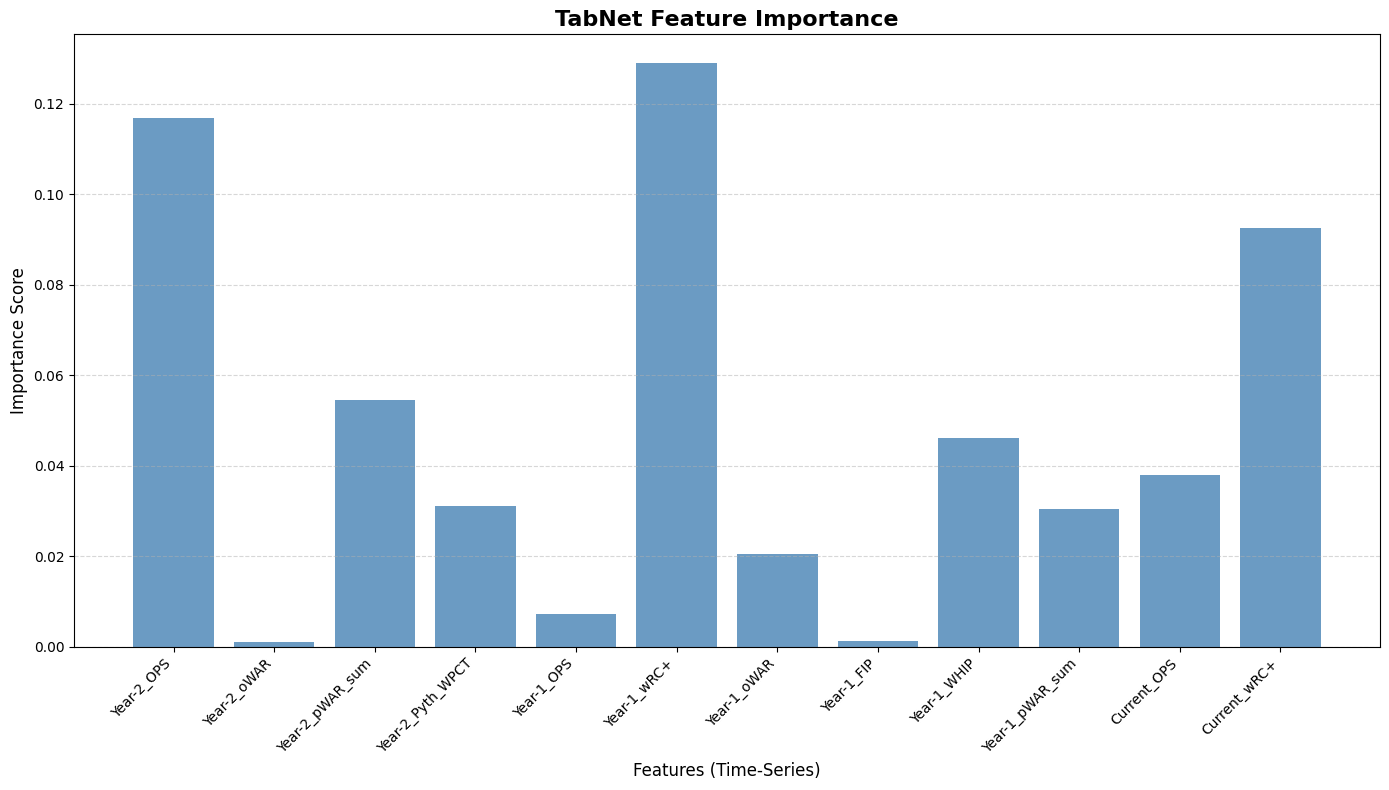

상위 10개 중요 변수
 1. Year-1_wRC+               : 0.1289
 2. Year-2_OPS                : 0.1169
 3. Current_wRC+              : 0.0925
 4. Year-2_pWAR_sum           : 0.0544
 5. Year-1_WHIP               : 0.0461
 6. Current_OPS               : 0.0380
 7. Year-2_Pyth_WPCT          : 0.0312
 8. Year-1_pWAR_sum           : 0.0305
 9. Year-1_oWAR               : 0.0204
10. Year-1_OPS                : 0.0072


In [47]:
import matplotlib.pyplot as plt

importance = regressor.feature_importances_

feature_names = []
years = ['Year-2', 'Year-1', 'Current']
for year in years:
    for feat in feature_cols:
        feature_names.append(f"{year}_{feat}")

non_zero_mask = importance[:len(feature_names)] > 0.001
filtered_names = [name for i, name in enumerate(feature_names) if non_zero_mask[i]]
filtered_importance = importance[:len(feature_names)][non_zero_mask]

plt.figure(figsize=(14, 8))
plt.bar(range(len(filtered_importance)), filtered_importance, color='steelblue', alpha=0.8)
plt.xticks(range(len(filtered_importance)), filtered_names, rotation=45, ha='right')
plt.title("TabNet Feature Importance", fontsize=16, fontweight='bold')
plt.ylabel("Importance Score", fontsize=12)
plt.xlabel("Features (Time-Series)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

top_indices = np.argsort(importance[:len(feature_names)])[-10:][::-1]

print("상위 10개 중요 변수")

for i, idx in enumerate(top_indices, 1):
    if idx < len(feature_names):
        print(f"{i:2d}. {feature_names[idx]:25s} : {importance[idx]:.4f}")

In [48]:
from scipy import stats

ridge_errors = np.abs(y_test - ridge_model.predict(X_test))
rf_errors = np.abs(y_test - rf_model.predict(X_test))
tabnet_errors = np.abs(y_test - regressor.predict(X_test).flatten())

t_stat_ridge, p_value_ridge = stats.ttest_rel(tabnet_errors, ridge_errors)

t_stat_rf, p_value_rf = stats.ttest_rel(tabnet_errors, rf_errors)

print("(Paired t-test)")
print(f"\nTabNet vs Ridge Regression")
print(f"   t-statistic: {t_stat_ridge:.4f}")
print(f"   p-value: {p_value_ridge:.4f}")
if p_value_ridge < 0.05:
    print(f"(p < 0.05)")
else:
    print(f"(p >= 0.05)")

print(f"\nTabNet vs Random Forest")
print(f"   t-statistic: {t_stat_rf:.4f}")
print(f"   p-value: {p_value_rf:.4f}")
if p_value_rf < 0.05:
    print(f"(p < 0.05)")
else:
    print(f" (p >= 0.05)")

(Paired t-test)

TabNet vs Ridge Regression
   t-statistic: 2.1510
   p-value: 0.0365
(p < 0.05)

TabNet vs Random Forest
   t-statistic: 1.1902
   p-value: 0.2398
 (p >= 0.05)
